In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm

pd.set_option('display.max_columns', None)

## Reading and data cleaning

In [3]:
df_p1 = pd.read_csv("data1.csv")
df_p2 = pd.read_csv("data2.csv")
df_p3 = pd.read_csv("data70_140.csv")
df_p4 = pd.read_csv("data140_210.csv")
df_p5 = pd.read_csv("data210_310.csv")
df_p6 = pd.read_csv("data310_410.csv")
df_p7 = pd.read_csv("data410_500.csv")
df_p8 = pd.read_csv("data500_510.csv")

df = pd.concat([df_p1, df_p2, df_p3, df_p4, df_p5, df_p6, df_p7, df_p8]).drop_duplicates()

df = df.rename(columns={"orientation.1":"orientation_desc", "floor.1":"floor_desc", "antiquity.1":"antiquity_desc", "conservationState.1":"conservationState_desc", "hotWater.1":"hotWater_type_desc", "heating.1":"heating_desc"})
bool_features_cols = [
    'furnished','parking', 'Aire acondicionado', 'Parquet', 'Horno', 'Microondas',
    'Serv. portería', 'Balcón', 'Lavadero', 'Armarios', 'Calefacción',
    'Suite - con baño', 'Nevera', 'Puerta Blindada', 'Terraza',
    'Electrodomésticos', 'Alarma', 'Cocina Equipada', 'Lavadora',
    'Cocina Office', 'Patio', 'Videoportero', 'Piscina', 'Gres Cerámica',
    'Jardín Privado', 'Trastero', 'Internet', 'Domótica', 'TV',
    'Ascensor interior', 'Sistema Video vigilancia CCTV 24h',
    'Z. Comunitaria', 'Zona Deportiva', 'Zona Infantil',
    'Piscina comunitaria', 'Gimnasio', 'Baño de huéspedes',
    'Cuarto para el servicio', 'Jacuzzi', 'Bodega', 'Sauna',
    'Cuarto lavado plancha', 'Energía Solar', 'elevator', 'Pista de Tenis', 'Porche cubierto'
] # df.columns[45:87]

for colname in bool_features_cols:
    df[colname] = np.where(df[colname]>0, True, False)

df = df[df["value"]>0]
df = df[df["value"].notna()]
df = df[(df["surface"]>0) & (df["surface"].notna()) & (df["surface"] < 1000)]
print(df.shape)

(9676, 114)


In [4]:
print(list(set(df.dtypes.to_list())))
# what to do with columns
# after consifderation, we decide to prevaler the descriptive features, as they are more reliable and give more information
# this can affect to the future, forcing us to do a data transformation of for example "6ª planta" to 6.
# hence, we drop the following 'int64' columns:
# type, transactions, transaction_type, periodicity_id, energyCertificate, surfaceLand, countryId, level1Id	level2Id	level3Id	level4Id	level5Id	level6Id	level7Id	level8Id
#         conservationState, orientation, hotwater, heating, antiquity, floor,
cols_drop = ["transactions", "transaction_type", "periodicity_id", "energyCertificate", "surfaceLand", "countryId", "level1Id",
             "level2Id", "level3Id", "level4Id", "level5Id", "level6Id", "level7Id", "level8Id",
             "conservationState", "orientation", "hotWater", "heating", "antiquity"] # , "floor"
try:
    df = df.drop(columns=cols_drop)
except:
    print("Some error ocurred. Maybe already dropped columns")


[dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')]


### Outliers removal

In [5]:
# Tukey's method is based on interquartile range (IQR) and is robust to skewed distributions, while the z-score method 
# relies on mean and standard deviation and is sensitive to extreme values. The choice between these methods depends 
# on the nature of your data and the specific requirements of your analysis. It's often a good practice to try both 
# methods and compare their effects on your data.

def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_zscore(df, column, threshold=2):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

df_iqr = remove_outliers_iqr(df, "value")
df_z = remove_outliers_zscore(df, "value")

print(f"IQR: {len(df_iqr)} | Actual: {len(df)} | {(len(df_iqr)/len(df))*100:.2f}%")
print(f"IQR: {len(df_z)} | Actual: {len(df)} | {(len(df_z)/len(df))*100:.2f}%")

IQR: 8892 | Actual: 9676 | 91.90%
IQR: 9325 | Actual: 9676 | 96.37%


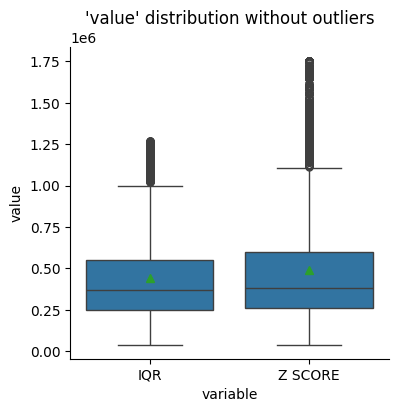

In [6]:
df_iqr = df_iqr.copy()
df_z = df_z.copy()

df_iqr['variable'] = 'IQR'
df_z['variable'] = 'Z SCORE'
combined_df = pd.concat([df_iqr, df_z], axis=0)
sns.catplot(data=combined_df, kind='box', x='variable', y='value', showmeans=True, height=4, aspect=1)
plt.title("'value' distribution without outliers")
plt.show()

In [80]:
df1 = df_iqr.reset_index(drop=True)

## Exploratory Data Analysis

In [81]:
df_des = df1.select_dtypes(include = ['O'])
df_num = df1.select_dtypes(include = ['int64','float64'])
df_bool = df1.select_dtypes(include = ['bool'])

### General Plots

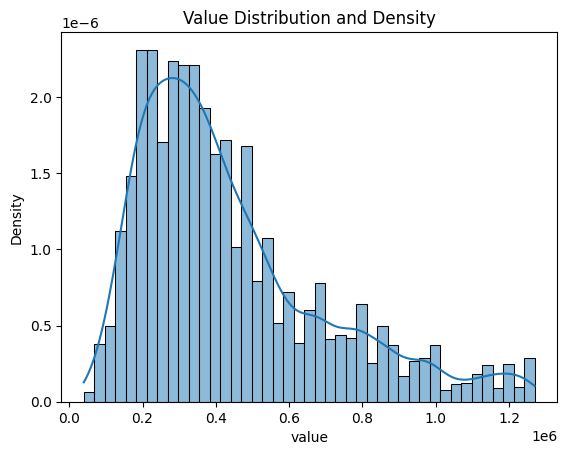

mean      440425.647211
median    370000.000000
std       258610.880245
count       8892.000000
Name: value, dtype: float64

In [82]:
# The main variable: Value
sns.histplot(df1.value, kde=True, stat="density")
plt.title("Value Distribution and Density")
plt.show()
df1['value'].agg(['mean', 'median', 'std', 'count'])

Hyphothesis of main variables: floor, square meters, neighborhood, antiquity, number of rooms

What we see:
- floor_desc

In [83]:
des_plot_features = ["orientation_desc","antiquity_desc","conservationState_desc","hotWater_type_desc","heating_desc"] # desc features
bool_plot_features = df_bool.columns

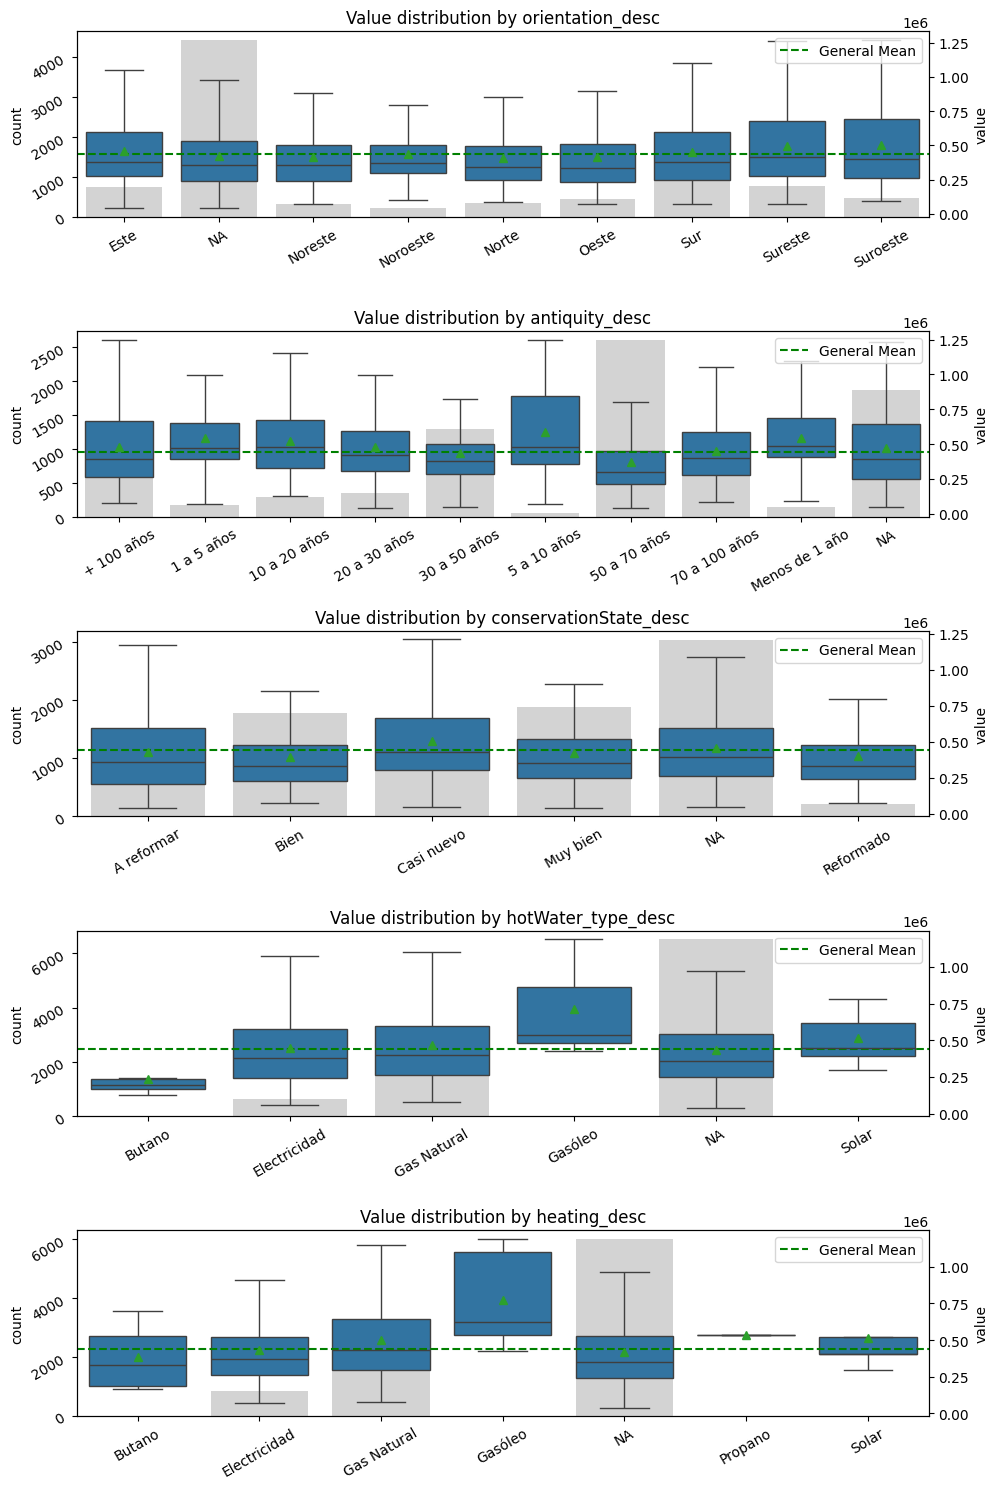

In [84]:
fig, ax1 = plt.subplots(nrows=len(des_plot_features), ncols=1, figsize=(10,len(des_plot_features)*3))

for i, feature in enumerate(des_plot_features):
    df_plot = df1[[feature, "value"]].fillna('NA').sort_values(feature)
    ax1[i].bar(df_plot[feature].unique(), df_plot.groupby(feature).size(), color='lightgrey')
    ax1[i].set_ylabel("count")
    ax2 = ax1[i].twinx()
    sns.boxplot(data=df_plot, x=feature, y='value', showfliers=False, showmeans=True, ax=ax2)
    plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
    ax1[i].tick_params(labelrotation=30)
    plt.legend(loc="upper right")
    plt.title(f"Value distribution by {feature}")

plt.tight_layout()
plt.show()

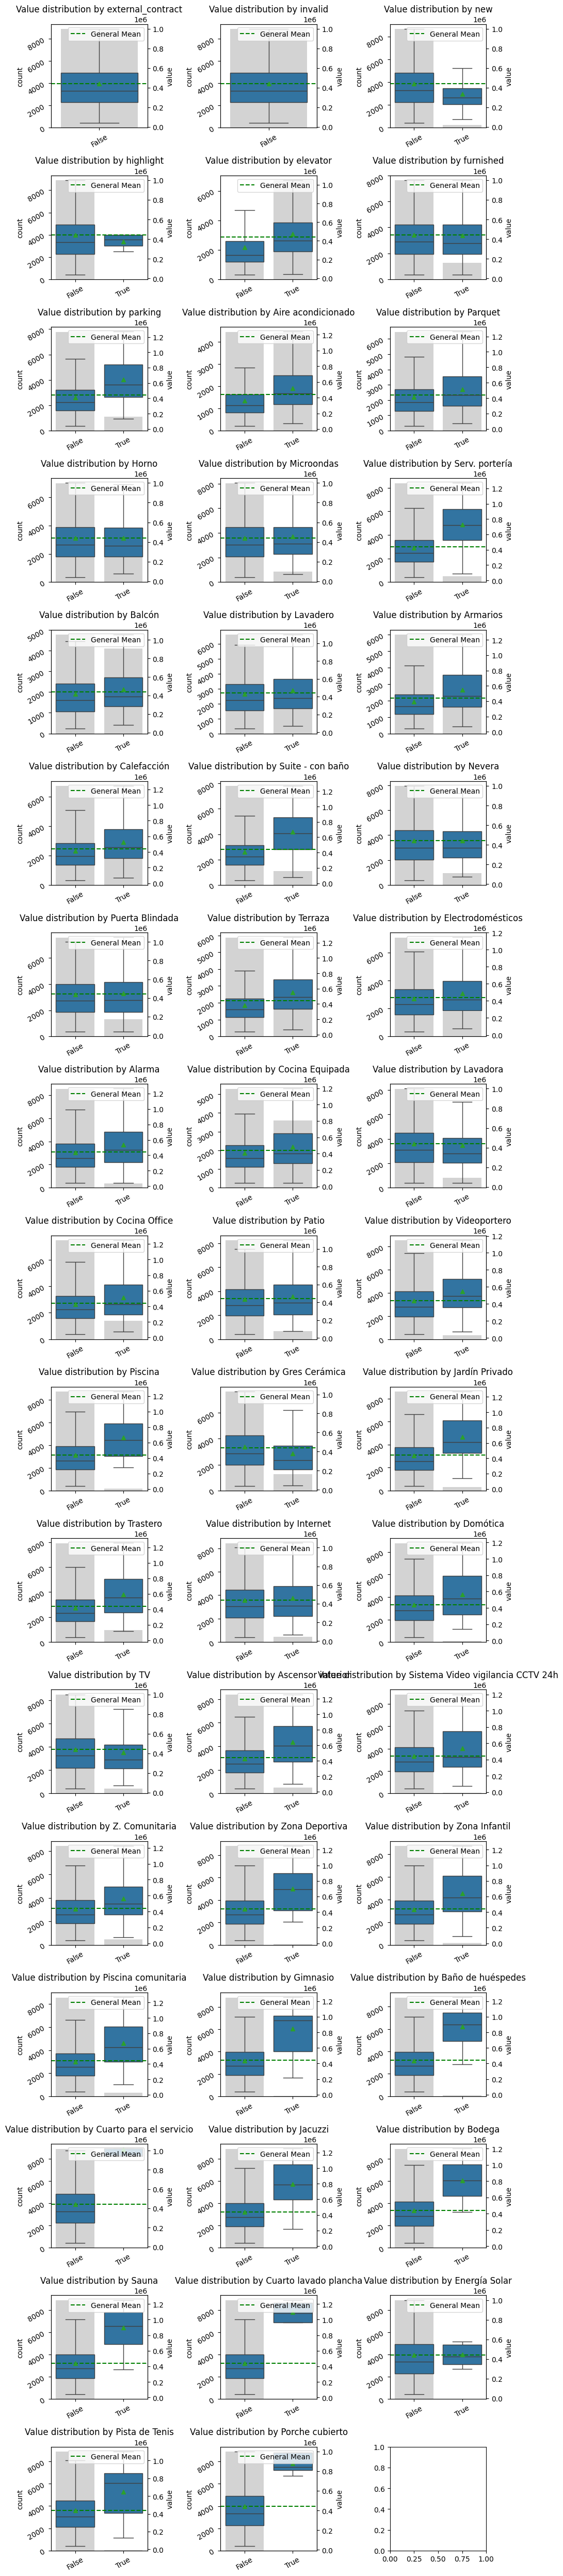

In [85]:
fig, ax1 = plt.subplots(nrows=int(np.ceil(len(bool_plot_features)/3)), ncols=3, figsize=(10,len(bool_plot_features)))

for i, feature in enumerate(bool_plot_features):
    df_plot = df1[[feature, "value"]].fillna('NA').sort_values(feature)
    ax1 = ax1.ravel()
    ax1[i].bar(df_plot[feature].unique(), df_plot.groupby(feature).size(), color='lightgrey')
    ax1[i].set_ylabel("count")
    ax2 = ax1[i].twinx()
    sns.boxplot(data=df_plot, x=feature, y='value', showfliers=False, showmeans=True, ax=ax2)
    plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
    ax1[i].tick_params(labelrotation=30)
    plt.legend(loc="upper right")
    plt.title(f"Value distribution by {feature}")

plt.tight_layout()
plt.show()

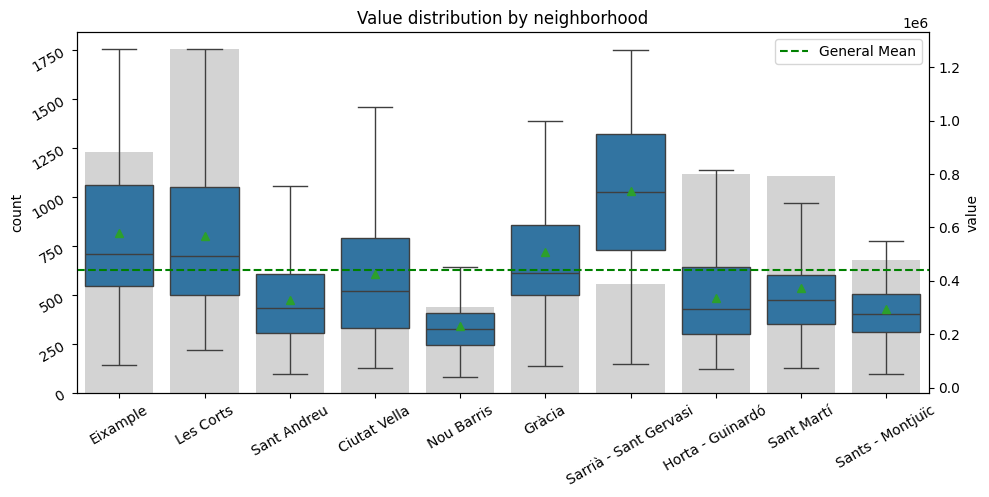

In [86]:
df_level_plot = df1[["level7", "value"]].fillna('NA')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(df_level_plot['level7'].unique(), df_level_plot.groupby('level7').size(), color='lightgrey')
ax1.set_ylabel("count")
ax2 = ax1.twinx()
sns.boxplot(data=df_level_plot, x='level7', y='value', showfliers=False, showmeans=True, ax=ax2)
plt.axhline(y=df_level_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
ax1.tick_params(labelrotation=30)
plt.tight_layout()
plt.legend()
plt.title("Value distribution by neighborhood")
plt.show()


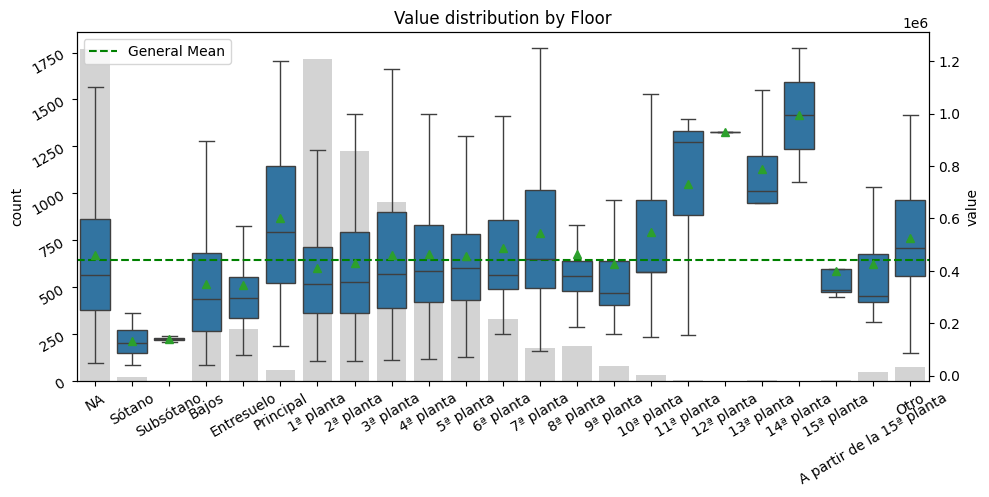

In [87]:
df_floor_plot = df1[["floor_desc", "value", "floor"]].fillna('NA').sort_values('floor')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(df_floor_plot['floor_desc'].unique(), df_floor_plot.groupby('floor').size(), color='lightgrey')
ax1.set_ylabel("count")
ax2 = ax1.twinx()
sns.boxplot(data=df_floor_plot, x='floor_desc', y='value', showfliers=False, showmeans=True, ax=ax2)
plt.axhline(y=df_floor_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
ax1.tick_params(labelrotation=30)
plt.tight_layout()
plt.legend()
plt.title("Value distribution by Floor")
plt.show()


In [88]:
# Explain why doing this type of mean
# np.mean(df1.value/df1.surface)
# np.mean(df1.value)/np.mean(df1.su
# np.sum(df1.value) / np.sum(df1.surface)rface)
# Es menos sensible a valores atípicos y variaciones extremas en los precios o tamaños de los pisos, ya que se basa en totales agregados.
# General mean is 4475.5086448770935
# Explain conclusion (583445.448674/107.054210)*138
stat = df1.groupby('level7')['value'].agg(['mean', 'count', 'sum']).rename(columns={"sum":"value_sum","mean":"value_mean"})
stat_value = df1.groupby('level7')['surface'].agg(['sum','mean']).rename(columns={"sum":"sqm_sum", "mean":"sqm_mean"})
stat_sqm = pd.merge(stat, stat_value, on='level7')
stat_sqm["value_per_sqm"] = stat_sqm["value_sum"] / stat_sqm["sqm_sum"]
stat_sqm.sort_values("value_per_sqm", ascending=False)

value_mean  count   value_sum  sqm_sum    sqm_mean  \
level7                                                                         
Eixample               580478.453820   1754  1018159208   187220  106.738883   
Sarrià - Sant Gervasi  735700.317109    678   498804815    93336  137.663717   
Les Corts              568517.644796    442   251284799    49332  111.610860   
Ciutat Vella           427327.840227   1233   526895227   108933   88.347932   
Gràcia                 506748.551418    564   285806183    59640  105.744681   
Sant Martí             373916.591071   1120   418786582    99835   89.138393   
Horta - Guinardó       334644.764787    727   243286744    65491   90.083906   
Sants - Montjuïc       293580.753153   1110   325874636    89294   80.445045   
Sant Andreu            328313.225000    560   183855406    50931   90.948214   
Nou Barris             232260.305398    704   163511255    57141   81.166193   

                       value_per_sqm  
level7                                
Eixample                 5438.303643  
Sarrià - Sant Gervasi    5344.184613  
Les Corts                5093.748459  
Ciutat Vella             4836.874290  
Gràcia                   4792.189520  
Sant Martí               4194.787219  
Horta - Guinardó         3714.811867  
Sants - Montjuïc         3649.457254  
Sant Andreu              3609.891932  
Nou Barris               2861.539963

In [89]:
df1.level8.value_counts()

level8
Dreta de l'Eixample                     467
El Raval                                456
Barri Gòtic                             349
L'Antiga Esquerra de l'Eixample         322
Sant Pere, Sta. Caterina i la Ribera    318
                                       ... 
Can Peguera                               3
Vallbona                                  3
Zona Franca - Port                        2
La Vall d'Hebron                          1
Baró de Viver                             1
Name: count, Length: 74, dtype: int64

In [90]:
stat = df1.groupby(['level8','level7'])['value'].agg(['mean', 'count', 'sum']).rename(columns={"sum":"value_sum","mean":"value_mean"})
stat_value = df1.groupby(['level8','level7'])['surface'].agg(['sum','mean']).rename(columns={"sum":"sqm_sum", "mean":"sqm_mean"})
stat_sqm = pd.merge(stat, stat_value, on=['level8','level7'])
stat_sqm["value_per_sqm"] = stat_sqm["value_sum"] / stat_sqm["sqm_sum"]
stat_sqm.sort_values("value_per_sqm", ascending=False).head(5)


value_mean  \
level8                                       level7                                 
Sarrià                                       Sarrià - Sant Gervasi  709466.176471   
La Clota                                     Horta - Guinardó       463666.666667   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí             590469.921875   
Dreta de l'Eixample                          Eixample               754540.246253   
Pedralbes                                    Les Corts              814582.524272   

                                                                    count  \
level8                                       level7                         
Sarrià                                       Sarrià - Sant Gervasi     68   
La Clota                                     Horta - Guinardó           9   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí               128   
Dreta de l'Eixample                          Eixample                 467   
Pedralbes                                    Les Corts                103   

                                                                    value_sum  \
level8                                       level7                             
Sarrià                                       Sarrià - Sant Gervasi   48243700   
La Clota                                     Horta - Guinardó         4173000   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí              75580150   
Dreta de l'Eixample                          Eixample               352370295   
Pedralbes                                    Les Corts               83902000   

                                                                    sqm_sum  \
level8                                       level7                           
Sarrià                                       Sarrià - Sant Gervasi     7340   
La Clota                                     Horta - Guinardó           654   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí               12068   
Dreta de l'Eixample                          Eixample                 57579   
Pedralbes                                    Les Corts                13792   

                                                                      sqm_mean  \
level8                                       level7                              
Sarrià                                       Sarrià - Sant Gervasi  107.941176   
La Clota                                     Horta - Guinardó        72.666667   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí              94.281250   
Dreta de l'Eixample                          Eixample               123.295503   
Pedralbes                                    Les Corts              133.902913   

                                                                    value_per_sqm  
level8                                       level7                                
Sarrià                                       Sarrià - Sant Gervasi    6572.711172  
La Clota                                     Horta - Guinardó         6380.733945  
Diagonal Mar i el Front Marítim del Poblenou Sant Martí               6262.856314  
Dreta de l'Eixample                          Eixample                 6119.771010  
Pedralbes                                    Les Corts                6083.381671

In [91]:
# Calculating the deviation from general mean
value_general_mean = np.mean(df1.value)
surface_general_mean = np.mean(df1.surface)
stat_sqm["dev_value_general"] = stat_sqm["value_mean"] / value_general_mean
stat_sqm["dev_surface_general"] = stat_sqm["sqm_mean"] / surface_general_mean
stat_sqm["diff_ratios_unfairness"] = stat_sqm["dev_value_general"] / stat_sqm["dev_surface_general"]
stat_sqm = stat_sqm.sort_values("diff_ratios_unfairness", ascending=False)
stat_sqm[["value_mean","sqm_mean","value_per_sqm","dev_value_general","dev_surface_general", "diff_ratios_unfairness"]].head()


value_mean  \
level8                                       level7                                 
Sarrià                                       Sarrià - Sant Gervasi  709466.176471   
La Clota                                     Horta - Guinardó       463666.666667   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí             590469.921875   
Dreta de l'Eixample                          Eixample               754540.246253   
Pedralbes                                    Les Corts              814582.524272   

                                                                      sqm_mean  \
level8                                       level7                              
Sarrià                                       Sarrià - Sant Gervasi  107.941176   
La Clota                                     Horta - Guinardó        72.666667   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí              94.281250   
Dreta de l'Eixample                          Eixample               123.295503   
Pedralbes                                    Les Corts              133.902913   

                                                                    value_per_sqm  \
level8                                       level7                                 
Sarrià                                       Sarrià - Sant Gervasi    6572.711172   
La Clota                                     Horta - Guinardó         6380.733945   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí               6262.856314   
Dreta de l'Eixample                          Eixample                 6119.771010   
Pedralbes                                    Les Corts                6083.381671   

                                                                    dev_value_general  \
level8                                       level7                                     
Sarrià                                       Sarrià - Sant Gervasi           1.610865   
La Clota                                     Horta - Guinardó                1.052769   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí                      1.340680   
Dreta de l'Eixample                          Eixample                        1.713207   
Pedralbes                                    Les Corts                       1.849535   

                                                                    dev_surface_general  \
level8                                       level7                                       
Sarrià                                       Sarrià - Sant Gervasi             1.114567   
La Clota                                     Horta - Guinardó                  0.750334   
Diagonal Mar i el Front Marítim del Poblenou Sant Martí                        0.973519   
Dreta de l'Eixample                          Eixample                          1.273111   
Pedralbes                                    Les Corts                         1.382640   

                                                                    diff_ratios_unfairness  
level8                                       level7                                         
Sarrià                                       Sarrià - Sant Gervasi                1.445283  
La Clota                                     Horta - Guinardó                     1.403069  
Diagonal Mar i el Front Marítim del Poblenou Sant Martí                           1.377148  
Dreta de l'Eixample                          Eixample                             1.345685  
Pedralbes                                    Les Corts                            1.337683

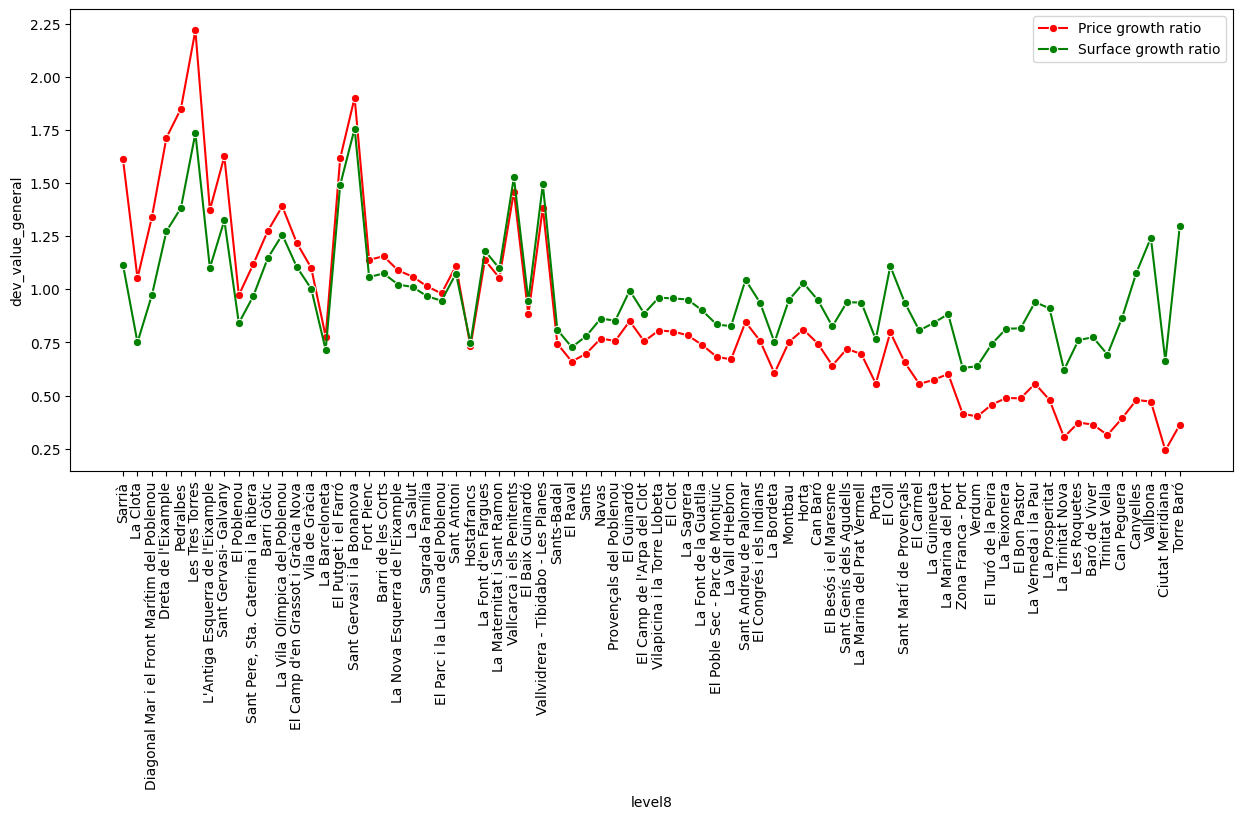

In [92]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=stat_sqm, x="level8", y="dev_value_general", marker='o', label="Price growth ratio", color="red")
sns.lineplot(data=stat_sqm, x="level8", y="dev_surface_general", marker='o', label="Surface growth ratio", color="green")
plt.legend()
plt.xticks(rotation=90)
plt.show()

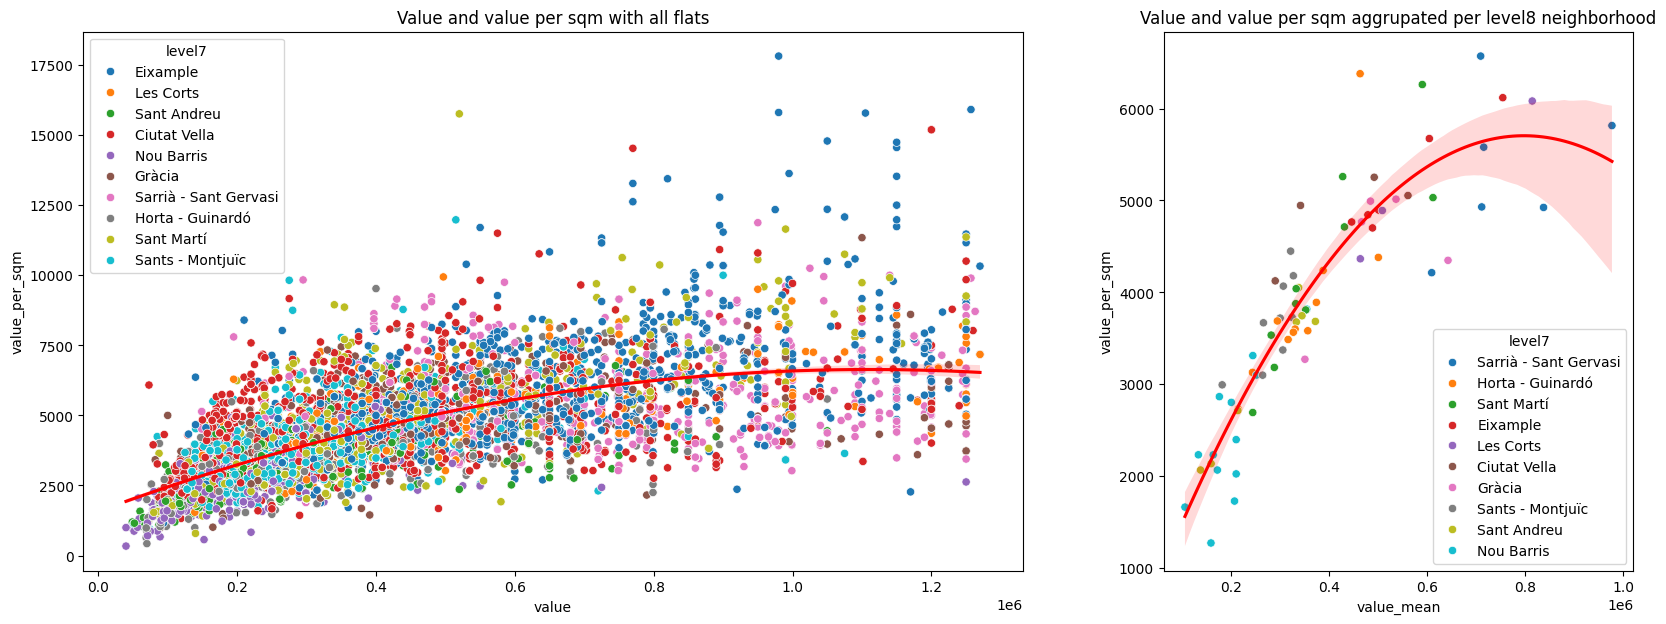

In [93]:
df1["value_per_sqm"] = df1["value"] / df1["surface"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), gridspec_kw={'width_ratios': [2, 1]})
sns.scatterplot(data=df1, x="value", y="value_per_sqm", hue="level7", ax=ax[0])
sns.regplot(data=df1, x='value', y='value_per_sqm', scatter=False, color='red', order=2, label='Trendline', ax=ax[0])
ax[0].set_title("Value and value per sqm with all flats")

sns.scatterplot(data=stat_sqm, x="value_mean", y="value_per_sqm", hue="level7", ax=ax[1])
sns.regplot(data=stat_sqm, x='value_mean', y='value_per_sqm', scatter=False, color='red', order=2, label='Trendline', ax=ax[1])
ax[1].set_title("Value and value per sqm aggrupated per level8 neighborhood")
plt.show()

In [95]:
# sns.lmplot(x="surface", y="value", hue="level7", col="level7", data=df1, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,)
df1 = df1[df1["energy_value"]<999]
#duplicates_columns = ["id","value","energy_value", "energy_letter","environment_value", "rooms", "bathrooms", "surface", "floor", "upperLevel"]
duplicates_columns = ["value", "energy_value", "energy_letter","environment_value", "rooms", "bathrooms", "surface", "floor", "upperLevel"]
#df1[(df1.value==265000) & (df1.level7=='Eixample')][duplicates_columns] # 36 "value","energy_value", "environment_value", "rooms", "bathrooms", "surface", "floor", "level8"
df1 = df1.drop_duplicates(subset=duplicates_columns, keep='first')
df1.shape


(4398, 97)

In [96]:
def get_color(value, min_val, max_val):
    # Normalize the value
    normalized = (value - min_val) / (max_val - min_val)
    # normalized = (np.log(value) - np.log(min_val)) / (np.log(max_val) - np.log(min_val))
    # Calculate RGB values
    r = int(255 * (1 - normalized))
    g = int(255 * normalized)
    b = 0
    # Convert to hexadecimal format
    color = '#{:02x}{:02x}{:02x}'.format(r, g, b)
    return color

# Find the min and max values of 'value' in your DataFrame
min_value = df1['value'].min()
max_value = df1['value'].max()


In [98]:
import folium

# Create a map centered around Barcelona
m = folium.Map(location=[41.3851, 2.1734], zoom_start=13, tiles='cartodbpositron')

# Add CircleMarkers for each location with color based on NumericalFeature
for index, row in df1.iterrows():
    fill_color = get_color(row['value'], min_value, max_value)
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,  # Adjust the radius of the circle marker
        popup=row['value'],
        fill=True,
        fill_color=fill_color,
        color=None,
        fill_opacity=0.7
    ).add_to(m)

# Display the map
m
